In [32]:
import xarray as xr
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from metpy.units import units
from metpy import calc as mpcalc

In [47]:
file = 'sggj_data.csv' 
dataset = pd.read_csv(file)
dataset_time_array = np.array(dataset['datetime'])
dataset_time_array_numpy = dataset_time_array.astype('datetime64[s]')
time_correction = datetime(1970, 1, 1, 0, 0, 0) - datetime(1904, 1, 1, 0, 0, 0)
time_correction_numpy = np.array([time_correction]).astype('timedelta64[s]')[0]
datetime_proper = dataset_time_array_numpy - time_correction_numpy
dataset['corrected_dts'] = datetime_proper
dataset['youngU'], dataset['youngV'] = mpcalc.wind_components(dataset['youngWS'].values * (units.meters/units.seconds),
                                                              dataset['youngWD'].values * units.deg)
dataset['gillU'], dataset['gillV'] = mpcalc.wind_components(dataset['gillWS'].values * (units.meters/units.seconds),
                                                            dataset['gillWD'].values * units.deg)
dataset['ftU'], dataset['ftV'] = mpcalc.wind_components(dataset['ftWS'].values * (units.meters/units.seconds),
                                                          dataset['ftWD'].values * units.deg)
dataset.set_index('corrected_dts', inplace=True, drop=True)
dataset.drop(columns=['datetime'], inplace=True)
dataset

/Users/stgardner4/micromamba/envs/tracer/lib/python3.12/site-packages/pandas/core/construction.py:631: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)
/Users/stgardner4/micromamba/envs/tracer/lib/python3.12/site-packages/pandas/core/construction.py:631: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)
/Users/stgardner4/micromamba/envs/tracer/lib/python3.12/site-packages/pandas/core/construction.py:631: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)
/Users/stgardner4/micromamba/envs/tracer/lib/python3.12/site-packages/pandas/core/construction.py:631: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)
/Users/stgardner4/micromamba/envs/tracer/lib/python3.12/site-packages/pandas/core/construction.py:63

,youngWS,youngWD,gillWS,gillWD,ftWS,ftWD,youngU,youngV,gillU,gillV,ftU,ftV
corrected_dts,,,,,,,,,,,,
2024-04-18 14:28:10,1.802,233.366,1.56,50.0,1.9,65.0,1.446039,1.075256,-1.195029,-1.002749,-1.721985,-0.802975
2024-04-18 14:28:11,2.176,215.749,2.96,78.0,2.4,63.0,1.271296,1.766007,-2.895317,-0.615419,-2.138416,-1.089577
2024-04-18 14:28:12,2.899,232.680,3.92,65.0,3.2,62.0,2.305464,1.757565,-3.552727,-1.656664,-2.825432,-1.502309
2024-04-18 14:28:13,2.833,200.615,3.23,51.0,3.2,49.0,0.997462,2.651596,-2.510181,-2.032705,-2.415071,-2.099389
2024-04-18 14:28:14,2.206,169.306,1.92,64.0,2.9,41.0,-0.409354,2.167687,-1.725685,-0.841673,-1.902571,-2.188658
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-19 14:34:23,5.221,200.142,4.56,58.0,4.3,65.0,1.797841,4.901695,-3.867099,-2.416432,-3.897123,-1.817259
2024-04-19 14:34:24,5.142,192.669,4.87,61.0,4.2,57.0,1.127735,5.016810,-4.259398,-2.361023,-3.522416,-2.287484
2024-04-19 14:34:25,4.912,227.797,3.98,54.0,4.3,56.0,3.638659,3.299682,-3.219888,-2.339385,-3.564862,-2.404529


Text(0, 0.5, 'wind speed (m/s)')

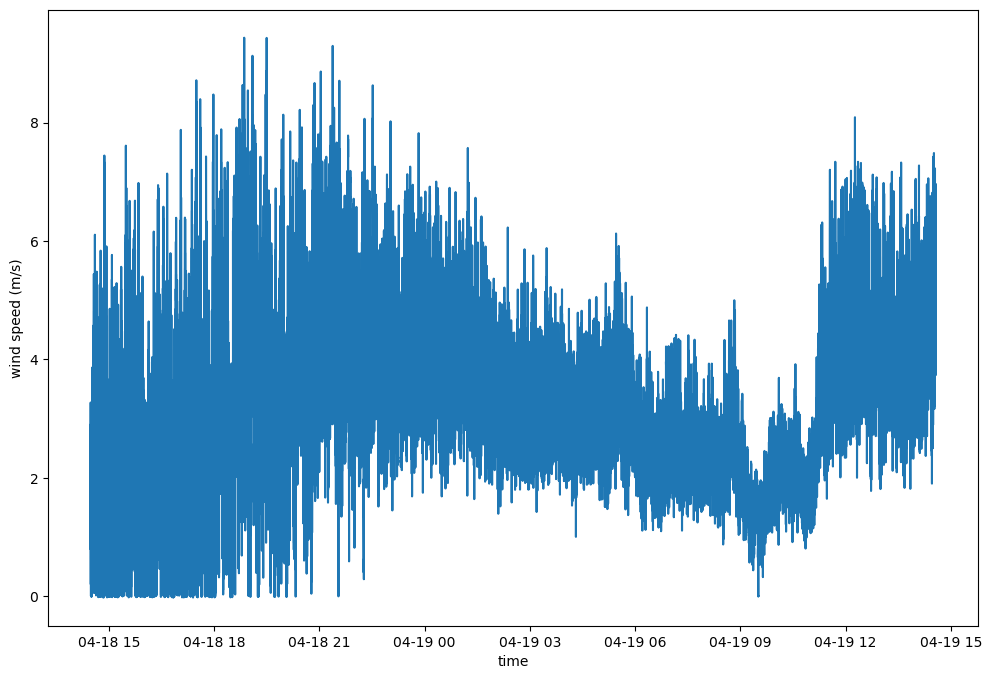

In [11]:
plt.figure(figsize = (12, 8))
plt.plot(dataset['corrected_dts'], dataset['youngWS'])
plt.xlabel('time')
plt.ylabel('wind speed (m/s)')

In [12]:
mean_young = np.mean(dataset['youngWS'])

In [13]:
young_dif_ws = np.power(np.subtract(dataset['youngWS'], mean_young),2)
young_ws_variance = young_dif_ws/np.size(dataset['youngWS'])
young_ws_std_dev = np.sqrt(young_ws_variance)

Text(0, 0.5, 'wind speed variance(m/s)')

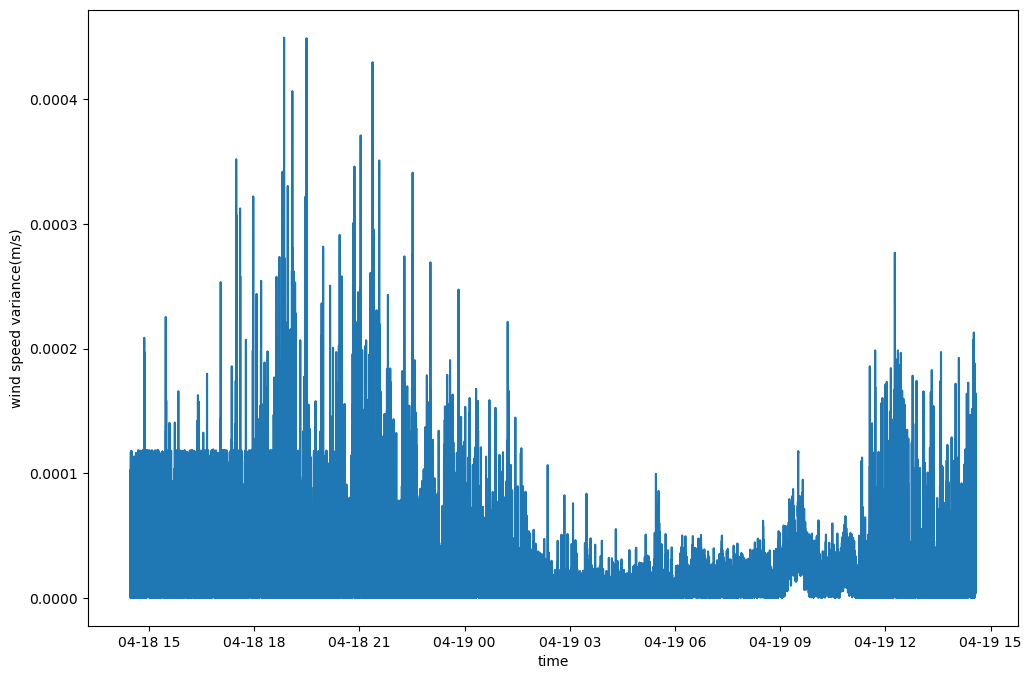

In [14]:
plt.figure(figsize = (12, 8))
plt.plot(dataset['corrected_dts'], young_ws_variance)
plt.xlabel('time')
plt.ylabel('wind speed variance(m/s)')

Text(0, 0.5, 'wind speed standard deviation (m/s)')

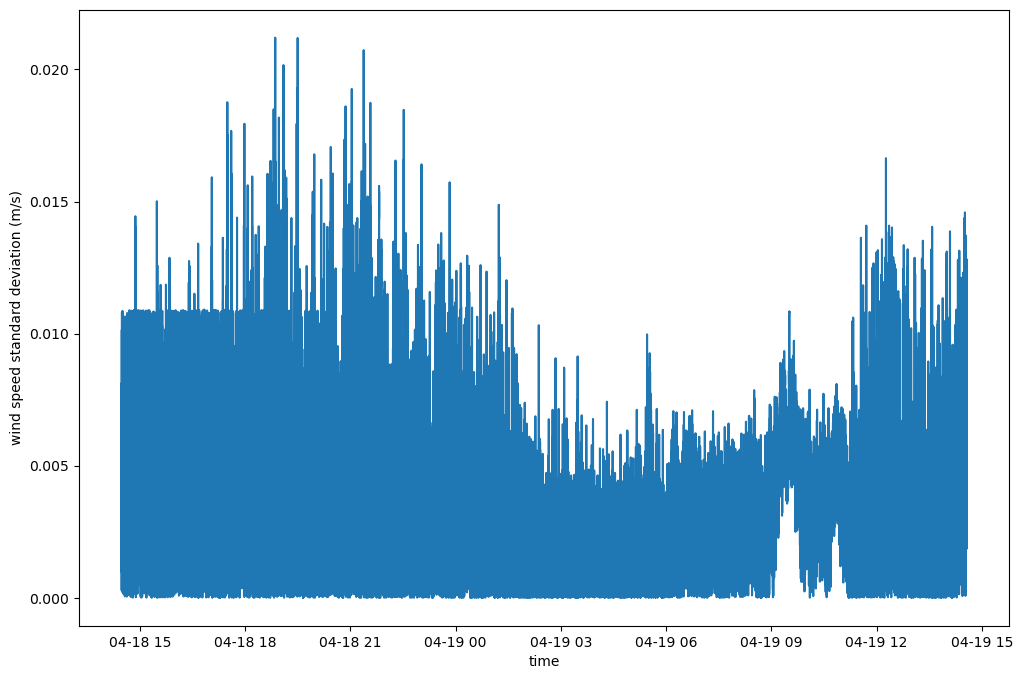

In [15]:
plt.figure(figsize = (12, 8))
plt.plot(dataset['corrected_dts'], young_ws_std_dev)
plt.xlabel('time')
plt.ylabel('wind speed standard deviation (m/s)')

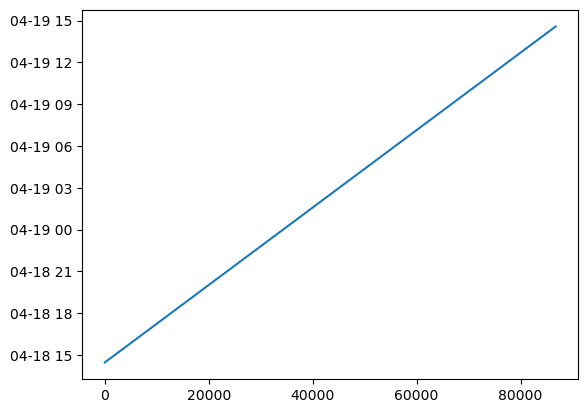

In [16]:
timeDriftFig = plt.figure()
timeDriftAx = timeDriftFig.gca()
timeDriftAx.plot(np.arange(0, np.size(dataset['corrected_dts'])), dataset['corrected_dts'])

In [24]:
expected_time_differences = np.arange(0, np.size(dataset['corrected_dts'])) * np.timedelta64(1000, 'ms')

In [25]:
expected_times = dataset['corrected_dts'][0] + expected_time_differences

In [28]:
timeDriftAx.plot(np.arange(0, np.size(dataset['corrected_dts'])), expected_times, color='gray')

In [30]:
dataset

,datetime,youngWS,youngWD,gillWS,gillWD,ftWS,ftWD,corrected_dts
0,3.796295e+09,1.802,233.366,1.56,50.0,1.9,65.0,2024-04-18 14:28:10
1,3.796295e+09,2.176,215.749,2.96,78.0,2.4,63.0,2024-04-18 14:28:11
2,3.796295e+09,2.899,232.680,3.92,65.0,3.2,62.0,2024-04-18 14:28:12
3,3.796295e+09,2.833,200.615,3.23,51.0,3.2,49.0,2024-04-18 14:28:13
4,3.796295e+09,2.206,169.306,1.92,64.0,2.9,41.0,2024-04-18 14:28:14
...,...,...,...,...,...,...,...,...
86750,3.796382e+09,5.221,200.142,4.56,58.0,4.3,65.0,2024-04-19 14:34:23
86751,3.796382e+09,5.142,192.669,4.87,61.0,4.2,57.0,2024-04-19 14:34:24
86752,3.796382e+09,4.912,227.797,3.98,54.0,4.3,56.0,2024-04-19 14:34:25
86753,3.796382e+09,4.245,228.743,4.22,63.0,4.0,67.0,2024-04-19 14:34:26
